In [144]:
import requests      
import numpy as np   
import pandas as pd  
import time
from fake_useragent import UserAgent
from bs4 import BeautifulSoup
import re
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

Парсинг раздела с горнолыжными ботинками магазина Кант, ссылка на каталог https://www.kant.ru/catalog/alpine-skis/alpine-boots/

В get_produck_info передаем ссылку на конкретный товар и получаем с нее часть информации о товаре 

In [63]:
def get_produck_info(product_link: str) -> list:
    response_product = requests.get(product_link, headers={'User-Agent': UserAgent().chrome})
    soup_product = BeautifulSoup(response_product.content, 'html.parser', from_encoding='utf-8') 

    price_str = soup_product.find('span', attrs={'class': "CatalogProduct_currentPrice__3kJLc"}).text
    price = int(re.sub(r'\D', '', price_str))

    name = soup_product.find('h1', attrs={'class': "CatalogProduct_mainTitle__IgGA9"}).text

    rating_str = soup_product.find('a', attrs={'class': "Rating_reviews__link__BAGhO"}).text
    rating = int(re.sub(r'\D', '', rating_str))    

    return [price, name, rating]

Часть информации о товарах, такую как ссылку на товар, скидку, жесткость и ширину получаем непосредественно с каталога со всеми товарами

In [64]:
page = 1
pages: list = []
df = pd.DataFrame(columns=['text', 'link', 'price', 'discount', 'rating', 'stiff', 'width'])

while True:
    time.sleep(2)
    main_page_link = f'https://www.kant.ru/catalog/alpine-skis/alpine-boots/?filter:page={page}&perPage=24&'
    response = requests.get(main_page_link, headers={'User-Agent': UserAgent().chrome})
    soup = BeautifulSoup(response.content, 'html.parser', from_encoding='utf-8') 

    if  len(soup.find_all('div', attrs={"data-index": True})) > 0:
        pages.append(soup)
        print(f'{page=}')
        page += 1
        #if page == 3: break
    else:
        break

    for i in range(24):  
        link = ''
        discount = ''
        tittle = ''
        price = 0 
        rating = 0
        stiff = 0
        width = ''

        time.sleep(1)  
        obj = soup.find('div', attrs={'data-index': i})
        if obj is None or len(obj.attrs) > 1: continue
        
        try:
            link = f'https://www.kant.ru{obj.find('a')['href']}'
            price, tittle, rating = get_produck_info(link)
            #print(price, tittle, rating, sep=', ')
        except:
            link = 'Не определено'

        try:
            discount = obj.find('div', attrs={'class': "ProductCard_labelsBottom__2ZDoa"}).find('span').text
        except:
            discount = 'Не определено'
        
        try:
            divs = obj.find_all('dl', attrs={'class': "ProductCard_characteristics__container__8YQgD"})
            for i in divs:
                if i.find('dt', attrs={'class': "ProductCard_characteristics__header__oM_1o"}).text == 'Жесткость ботинка':
                    stiff = int(i.find('dd', attrs={'class': "ProductCard_characteristics__text__W4obp"}).text)
                elif i.find('dt', attrs={'class': "ProductCard_characteristics__header__oM_1o"}).text == 'Ширина колодки':
                    width = i.find('dd', attrs={'class': "ProductCard_characteristics__text__W4obp"}).text
        except:
            stiff = 'Не определено'
            width = 'Не определено'

        df = pd.concat([df, pd.DataFrame([[tittle, link, price, discount, rating, stiff, width]], columns=['text', 'link', 'price', 'discount', 'rating', 'stiff', 'width'])], ignore_index=True) 

page=1
page=2
page=3
page=4
page=5
page=6
page=7
page=8
page=9
page=10
page=11
page=12
page=13
page=14
page=15
page=16
page=17


In [130]:
df.sample(3)

,text,link,price,discount,rating,stiff,width
80,Горнолыжные ботинки FISCHER RC4 PRO MV DYN BOA...,https://www.kant.ru/catalog/product/1918754-go...,69300,-30%,1,130,средняя (99-101)
278,Горнолыжные ботинки FISCHER RC4 85 HV GW Black,https://www.kant.ru/catalog/product/1851377-go...,26650,-35%,0,85,широкая (более 101)
110,Горнолыжные ботинки ROXA RX Scout W Black/Torq...,https://www.kant.ru/catalog/product/1608067-go...,34780,-30%,0,100,узкая (меньше 99)


In [ ]:
#df.to_excel('skis.xlsx', index=False)

Дполнительно из описания товара получим бренд

In [131]:
df_copy = df.copy()

In [138]:
df_copy.sample(2)

,text,link,brand,price,discount,rating,stiff,width
363,Горнолыжные ботинки детские ROXA Lazer 1 GW Li...,https://www.kant.ru/catalog/product/1679071-go...,ROXA,9490,Не определено,0,10,средняя (99-101)
252,Горнолыжные ботинки SALOMON S/Pro Alpha 80 GW ...,https://www.kant.ru/catalog/product/1954742-go...,SALOMON,35180,-30%,0,80,узкая (меньше 99)


In [132]:
brands = ['ATOMIC', 'ELAN', 'FISCHER', 'HEAD', 'LANGE', 'ROXA', 'SALOMON', 'Scarpa', 'SCOTT', 'Tecnica']
series_brand = df_copy['text'].apply(lambda x: next((brand for brand in brands if brand in x), 'Не определено'))
df_copy.insert(2, 'brand', series_brand)


Посмотрим сколько встречается в штуках товара по характеристиках и распределение цены

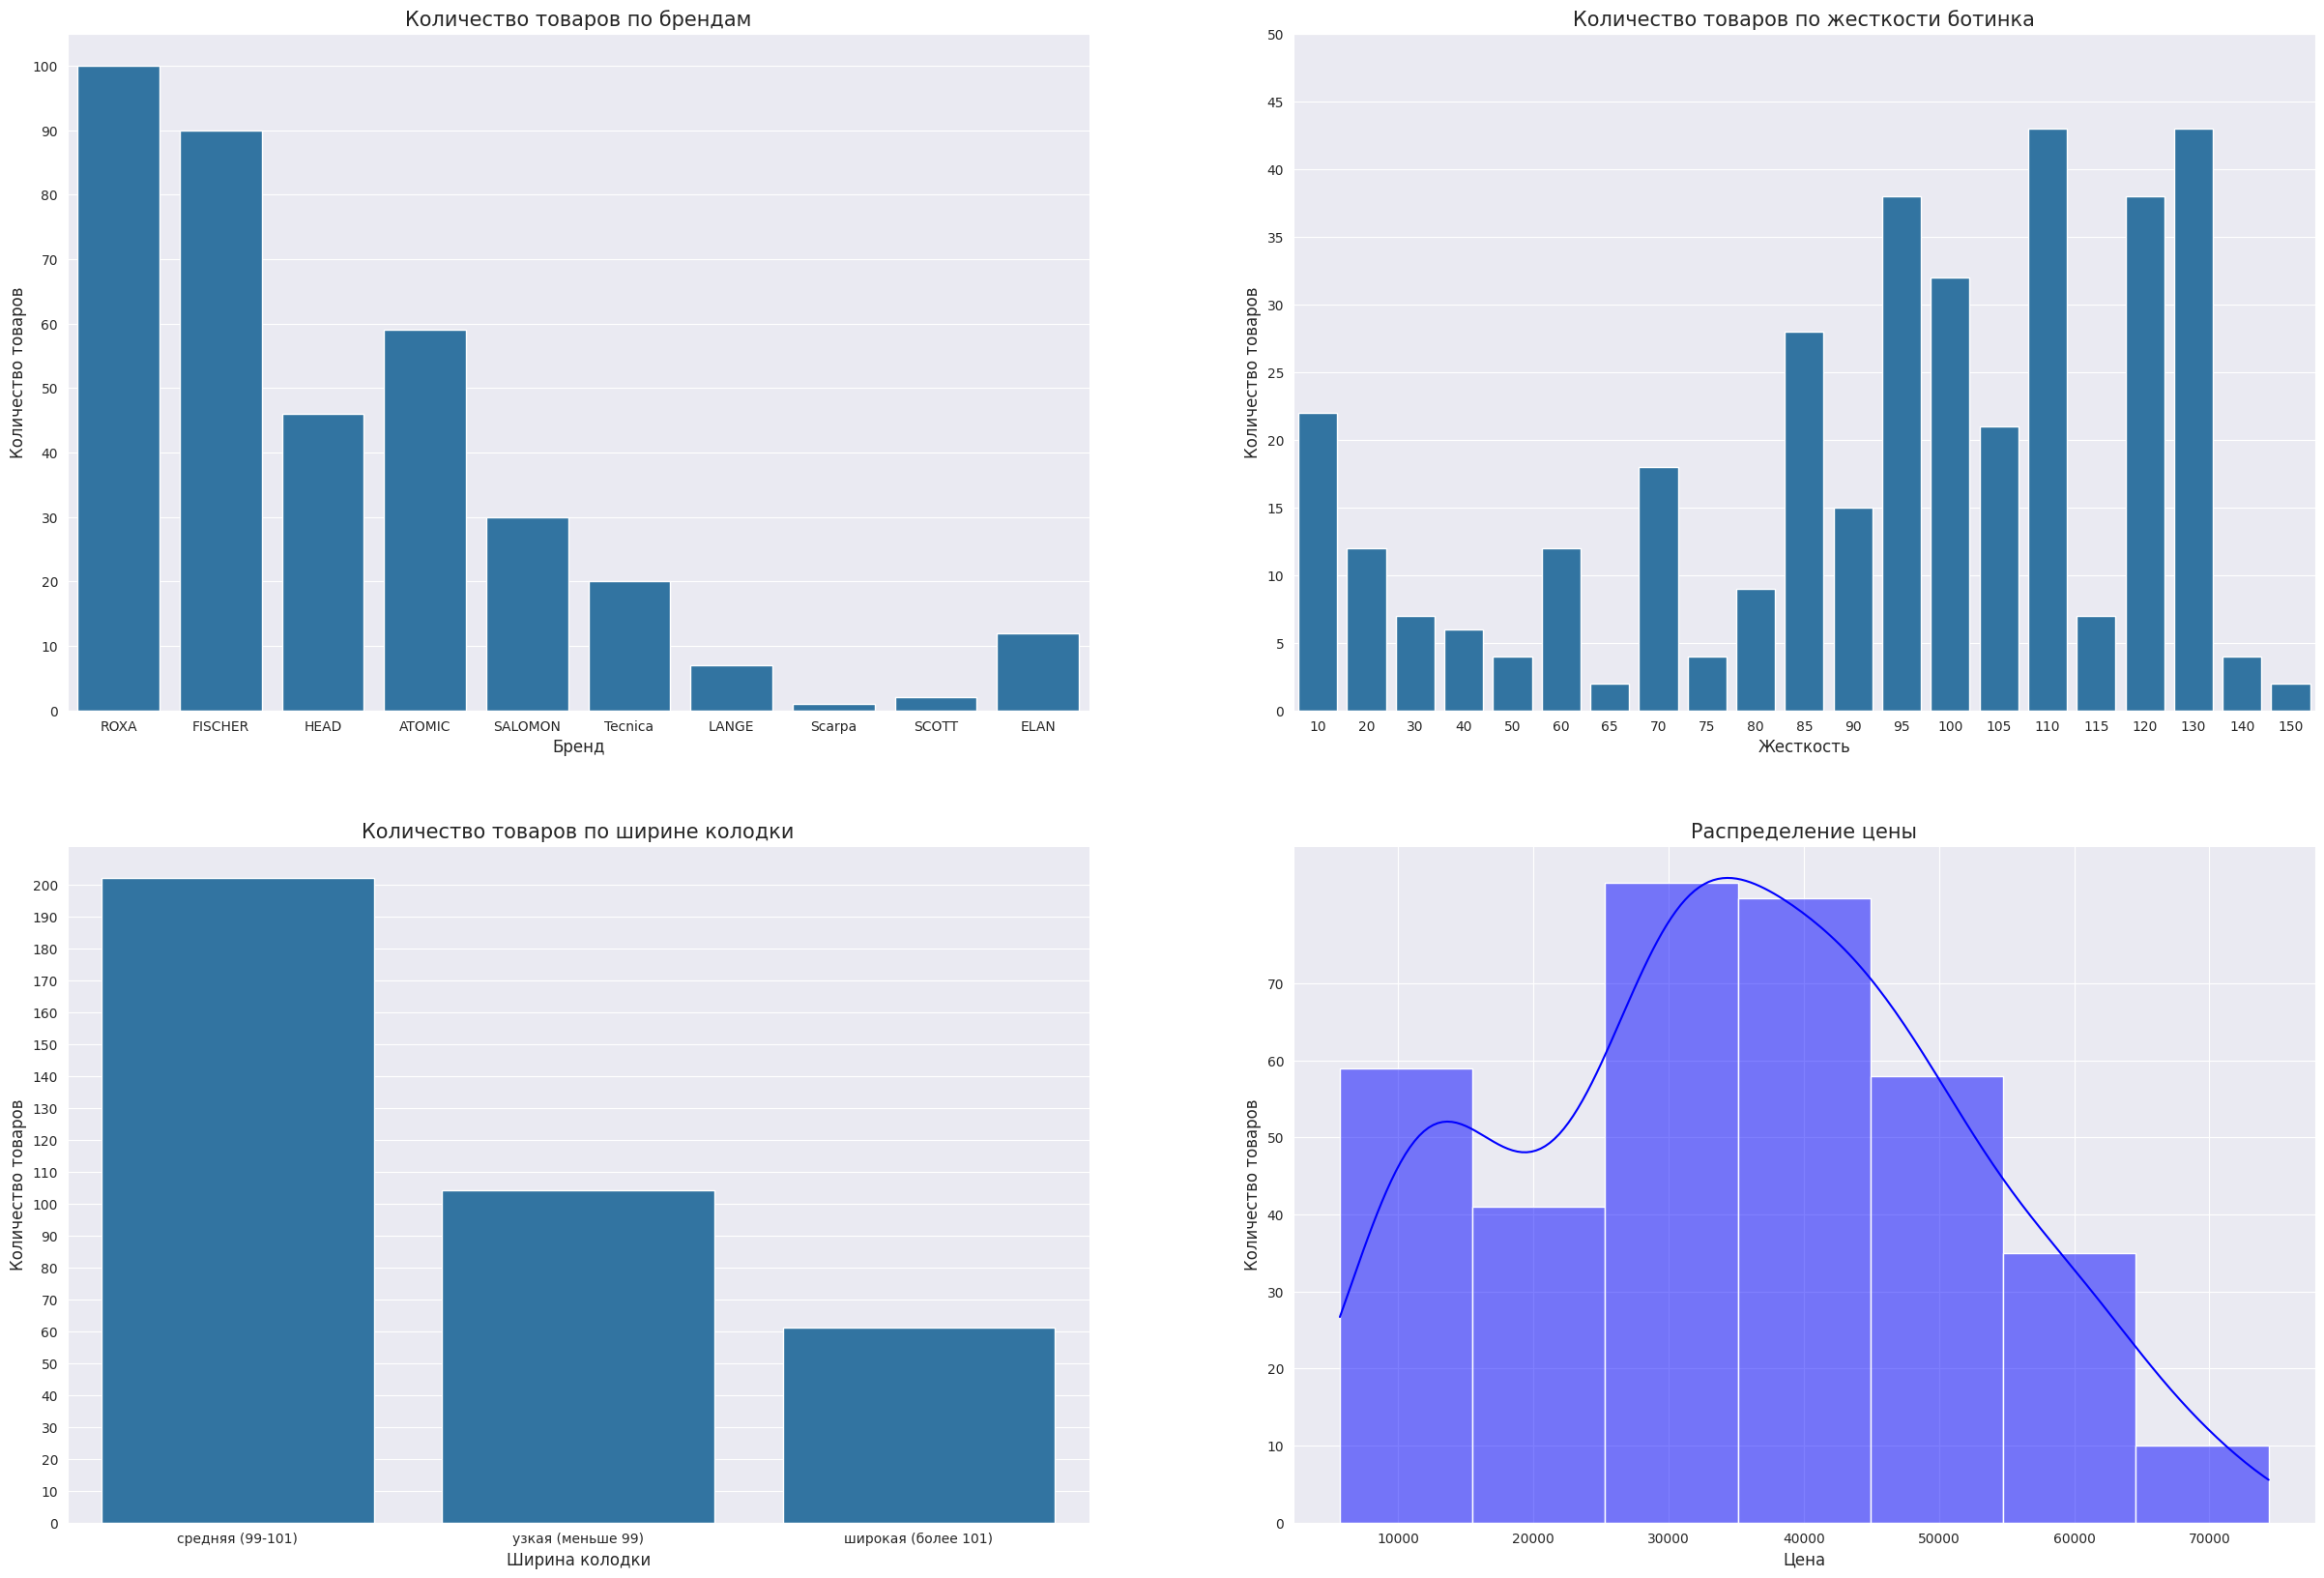

In [192]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30, 20))
sns.countplot(data=df_copy, x='brand', ax=ax1)
ax1.set_title('Количество товаров по брендам', fontdict={'fontsize': 15})
ax1.set_xlabel('Бренд', fontdict={'fontsize': 12})
ax1.set_ylabel('Количество товаров', fontdict={'fontsize': 12})
ax1.set_yticks(range(0, 105, 10))

sns.countplot(data=df_copy, x='stiff', ax=ax2)
ax2.set_title('Количество товаров по жесткости ботинка', fontdict={'fontsize': 15})
ax2.set_xlabel('Жесткость', fontdict={'fontsize': 12})
ax2.set_ylabel('Количество товаров', fontdict={'fontsize': 12})
ax2.set_yticks(range(0, 55, 5))

sns.countplot(data=df_copy, x='width', ax=ax3)
ax3.set_title('Количество товаров по ширине колодки', fontdict={'fontsize': 15})
ax3.set_xlabel('Ширина колодки', fontdict={'fontsize': 12})
ax3.set_ylabel('Количество товаров', fontdict={'fontsize': 12})
ax3.set_yticks(range(0, 210, 10))

sns.histplot(df_copy['price'], kde=True, bins=7, color='blue', ax=ax4)
ax4.set_title('Распределение цены', fontdict={'fontsize': 15})
ax4.set_xlabel('Цена', fontdict={'fontsize': 12})
ax4.set_ylabel('Количество товаров', fontdict={'fontsize': 12})
ax4.set_yticks(range(0, 80, 10))

plt.show()

Постмотрим на кол-во ботинок в зависмости от бренда и жесткости

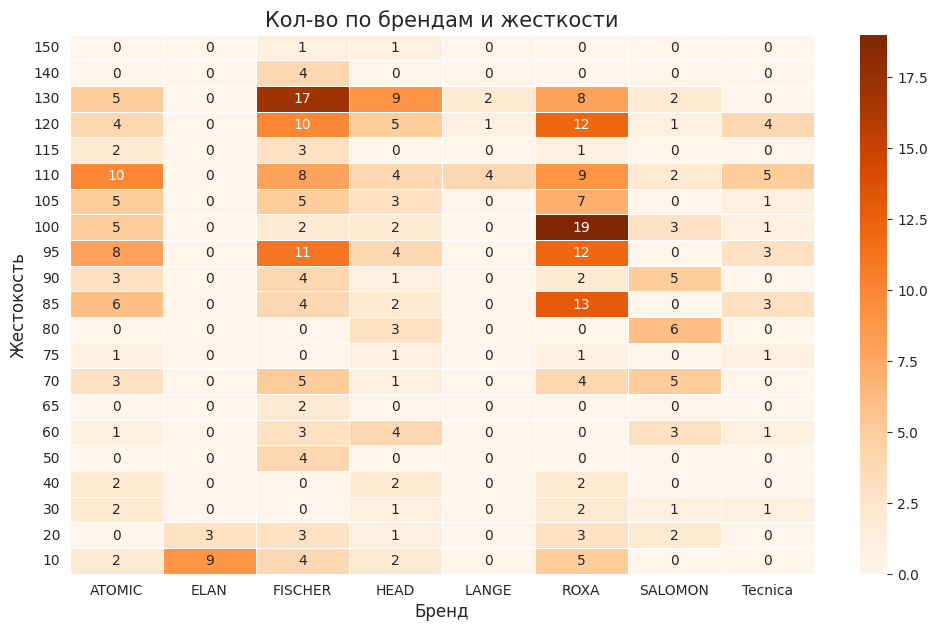

In [274]:
df_price_brand = df_copy[~df_copy['brand'].isin(['Scarpa', 'SCOTT'])]
pivot_table = df_price_brand.pivot_table(index='stiff', columns='brand', values='price', aggfunc='count', fill_value=0)
pivot_table = pivot_table.iloc[::-1]

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(pivot_table, annot=True, fmt='g', cmap="Oranges", linewidths=0.5)

plt.title('Кол-во по брендам и жесткости', fontdict={'fontsize': 15})
plt.xlabel('Бренд', fontdict={'fontsize': 12})
plt.ylabel('Жестокость', fontdict={'fontsize': 12})

plt.show()

Посмотрим как зависит цена от разных параметров

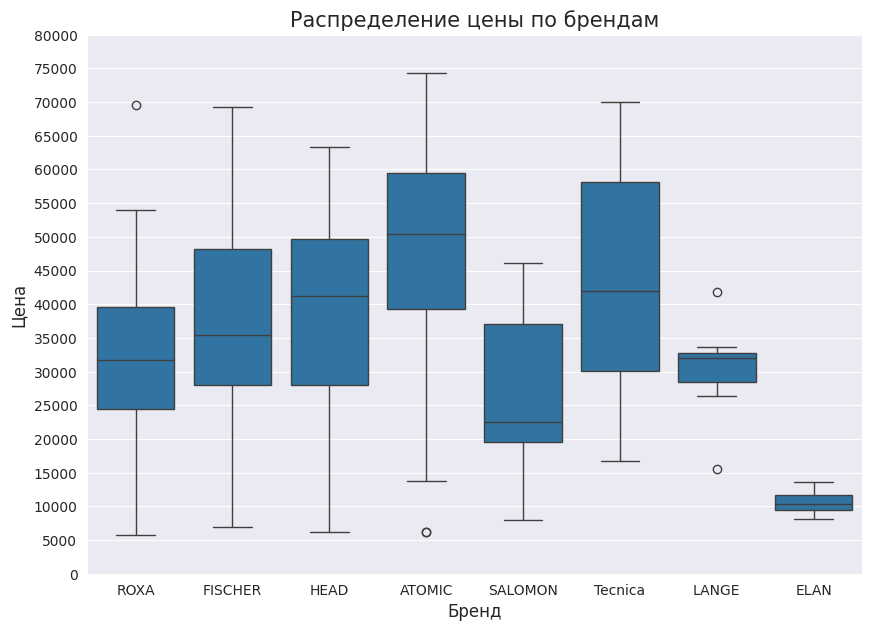

In [283]:
fig, ax1 = plt.subplots(figsize=(10, 7))

sns.boxplot(data=df_price_brand, y='price', x='brand')
plt.title('Распределение цены по брендам', fontdict={'fontsize': 15})
plt.xlabel('Бренд', fontdict={'fontsize': 12})
plt.ylabel('Цена', fontdict={'fontsize': 12})
plt.yticks(range(0, 85000, 5000))
plt.show()

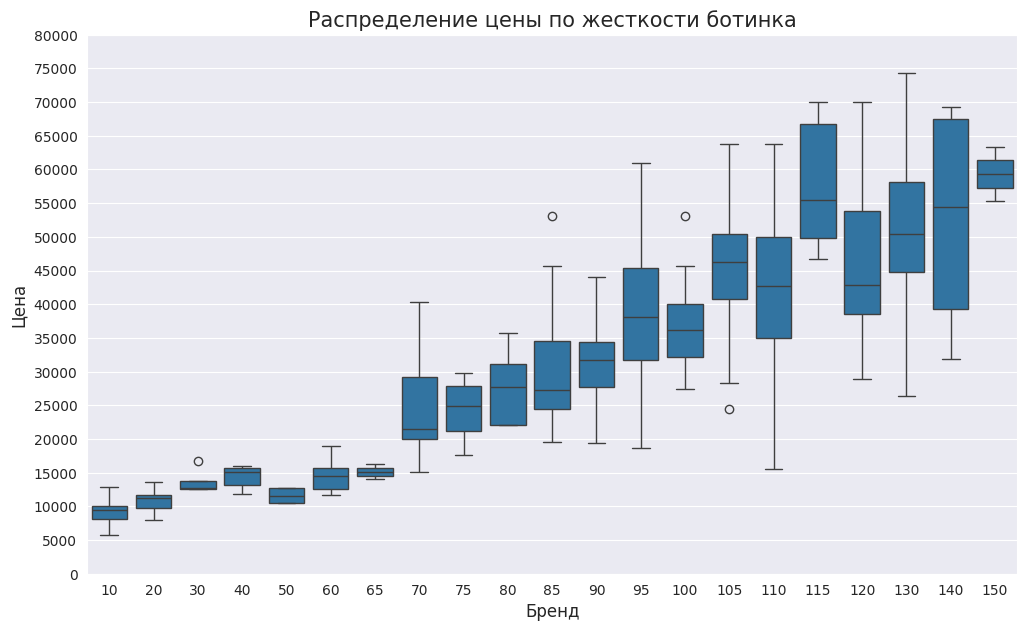

In [230]:
df_price_brand = df_copy[~df_copy['brand'].isin(['Scarpa', 'SCOTT'])]
fig, ax = plt.subplots(figsize=(12, 7))

sns.boxplot(data=df_price_brand, y='price', x='stiff')
plt.title('Распределение цены по жесткости ботинка', fontdict={'fontsize': 15})
plt.xlabel('Бренд', fontdict={'fontsize': 12})
plt.ylabel('Цена', fontdict={'fontsize': 12})
plt.yticks(range(0, 85000, 5000))
plt.show()

Выводы:

Самые широко представленные жесткости - 110 и 130, далее 120 и 95.  
Большинство ботинок в цене по диапазоне 30-50 т.р.  
Медианная цена для жесткости 110 и 120 - 42.5 т.р., для жесткости 130 - около 50 т.р.  
Из брендов, у которых есть жестости от 110 и выше - самый дешевый Roxa, чуть дороже Fisher, еще дороже Head, самые дорогие - Atomic  
